# Agents with LlamaIndex  

Sources [1](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/), [2](https://docs.llamaindex.ai/en/stable/understanding/putting_it_all_together/agents/), [3](https://docs.llamaindex.ai/en/stable/examples/agent/custom_agent/), [4](https://docs.llamaindex.ai/en/stable/examples/agent/openai_agent/), [5](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/agent_runner/), [6](https://medium.com/llamaindex-blog/data-agents-eed797d7972f)  

Data Agents, empowered by LLMs are knowledge workers within LlamaIndex, designed to interact with various types of data. These agents can handle both unstructured and structured data, significantly enhancing the capabilities beyond traditional query/chat engines.

![](https://miro.medium.com/v2/resize:fit:1000/format:webp/1*cWwW01Ez_JIS2hcMJwcV8Q.png)  

Here's a high level overview about it:

+ Functionality: Data Agents can autonomously conduct searches and retrieve information across unstructured, semi-structured, and structured data. They are not limited to just reading data; they can also write, modify, and store information by integrating with external service APIs.

+ Dynamic Interaction: Unlike static query/chat engines, Data Agents can dynamically interact with data sources. They can ingest new data and adapt based on the information they process, offering a more flexible and responsive approach to data management.

Building a data agent requires the following core components:

1. Reasoning loop
2. Tool abstractions

![](https://miro.medium.com/v2/resize:fit:1000/format:webp/1*WPOS7tiljXCrd3IkJy84CQ.png)  

A data agent is initialized with set of APIs, or Tools, to interact with; these APIs can be called by the agent to return information or modify state. Given an input task, the data agent uses a reasoning loop to decide which tools to use, in which sequence, and the parameters to call each tool.

---

1. Reasoning Loop - The reasoning loop depends on the type of agent, as following:
    + ReAct agent (works across any chat/text completion endpoint). - [Video](https://www.youtube.com/watch?v=pRUc6JPw6CY) [Code](https://colab.research.google.com/drive/1XYNaGvEdyKVbs4g_Maffyq08DUArcW8H?usp=sharing)  
    + Function Calling Agents (integrates with any function calling LLM) - [Video](https://www.youtube.com/watch?v=6INvyrC4WrA) [Code](https://colab.research.google.com/drive/1GyPRMiwxS7rKxKpRt4r-ckYfmAw2GxdQ?usp=sharing)  
    + "Advanced Agents": 
        + Retrieval Augmented Function Calling Agent - [Video](https://www.youtube.com/watch?v=K7h17Jjtbzg) [Code](https://colab.research.google.com/drive/1R41zIhVybCNqg67eVEPuyLeMp_HYwTlA?usp=sharing)  
        + Controlling Agent Reasoning Loop - [Video](https://www.youtube.com/watch?v=gFRbkRtLGZQ) [Code](https://colab.research.google.com/drive/1c5ORIlqs3YMWosDSMgs6_ZHb5eiANS1c?usp=sharing)  
        + StepWise Controllable Agent - [Video](https://www.youtube.com/watch?v=JGkSxdPFgyQ) [Code](https://colab.research.google.com/drive/1x-CR_KA7LzhPhLdITycojAJVamEaKsaO?usp=sharing)  
        + [LLMCompiler](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-llm-compiler?from=)  
        + [Chain-of-Abstraction](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-coa?from=)  
        + [Language Agent Tree Search](https://llamahub.ai/l/llama-packs/llama-index-packs-agents-lats?from=)  
        + and more...

---

2. Tool Abstractions - At their core, tool abstractions allow for a structured way to define how Data Agents can interact with data or services. Unlike typical APIs designed for human users, these tools are optimized for automated interactions, enabling agents to execute tasks with precision and efficiency.

Types of Tools:

+ FunctionTool - A function tool allows users to easily convert any user-defined function into a Tool. It can also auto-infer the function schema.
+ QueryEngineTool - A tool that wraps an existing query engine. 

[LlamaHub Tools](https://llamahub.ai/?tab=tools)  
    
--- 

## Installing Packages

In [ ]:
!pip install -q openai
!pip install -q llama-index
!pip install llama-index-experimental
!pip install -q pypdf
!pip install -q docx2txt

## Importing Packages

In [2]:
import os
#os.environ["OPENAI_API_KEY"] = "<the key>"

import sys
import shutil
import glob
import logging
from pathlib import Path
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import openai
from llama_index.llms.openai import OpenAI

## Llamaindex readers
from llama_index.core import SimpleDirectoryReader

## LlamaIndex Index Types
from llama_index.core import ListIndex
from llama_index.core import VectorStoreIndex
from llama_index.core import TreeIndex
from llama_index.core import KeywordTableIndex
from llama_index.core import SimpleKeywordTableIndex
from llama_index.core import DocumentSummaryIndex
from llama_index.core import KnowledgeGraphIndex
from llama_index.experimental.query_engine import PandasQueryEngine

## LlamaIndex Context Managers
from llama_index.core import StorageContext
from llama_index.core import load_index_from_storage
from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core.schema import Node

## LlamaIndex Templates
from llama_index.core.prompts import PromptTemplate
from llama_index.core.prompts import ChatPromptTemplate
from llama_index.core.base.llms.types import ChatMessage, MessageRole

## LlamaIndex Agents
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent

## LlamaIndex Callbacks
from llama_index.core.callbacks import CallbackManager
from llama_index.core.callbacks import LlamaDebugHandler

import nest_asyncio
nest_asyncio.apply()

In [3]:
import logging

#logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
#logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# 1st. Example - [Router Engine](https://docs.llamaindex.ai/en/stable/module_guides/querying/router/)  

![](https://miro.medium.com/v2/resize:fit:1000/1*pwwxzWABv4cJDWonJ7LImg.png)

+ The source document is indexed with sentence splitting with a fixed window size
+ Create summary and vector indexes
+ From indices, we obtain query engines, respectively
+ Bind all search engines to the agents as tools
+ The agent will choose a tool based on the overall prompts
+ Query on the agent.

In [5]:
DOCS_DIR = "./data/"
PERSIST_DIR = "./index/"

print(f"Current dir: {os.getcwd()}")

if not os.path.exists(DOCS_DIR):
  os.mkdir(DOCS_DIR)
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)

Current dir: /home/renato/Documents/Repos/GenAI4Humanists/Notebooks
Files in ./data/
1.pdf
california_housing_train.csv
metagpt.pdf
paul_graham_essay.txt
pg58031.text


## Load Data  

#### To download this paper, below is the needed code:

In [1]:
#!wget "https://openreview.net/pdf?id=VtmBAGCN7o" -O ./data/metagpt.pdf

--2024-05-16 18:39:11--  https://openreview.net/pdf?id=VtmBAGCN7o
Resolving openreview.net (openreview.net)... 35.184.86.251
Connecting to openreview.net (openreview.net)|35.184.86.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16911937 (16M) [application/pdf]
Saving to: ‘./data/metagpt.pdf’

./data/metagpt.pdf  100%[===================>]  16,13M  1,74MB/s    in 9,4s    

2024-05-16 18:39:21 (1,72 MB/s) - ‘./data/metagpt.pdf’ saved [16911937/16911937]



In [6]:
documents = SimpleDirectoryReader(input_files=["./data/metagpt.pdf"]).load_data()

## Define LLM and Embedding model

In [7]:
from llama_index.core.node_parser import SentenceSplitter

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

In [10]:
print(len(nodes))
nodes[0]

34


TextNode(id_='26d08d8a-f223-42ce-89d5-f48cf42e00b4', embedding=None, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='92b27c12-0691-489c-a338-4449ed1b2787', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}, hash='854f7a62f51dbb500255e0c0f1c72edefe216574ab7b796a6cf71ea46d455ebe')}, text='Preprint\nMETAG

In [11]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")

## Define Summary Index and Vector Index over the Same Data

In [12]:
from llama_index.core import SummaryIndex, VectorStoreIndex

summary_index = SummaryIndex(nodes)
vector_index = VectorStoreIndex(nodes)

## Define Query Engines Tools and Set Metadata for each Tool

In [13]:
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)

vector_query_engine = vector_index.as_query_engine()

In [14]:
from llama_index.core.tools import QueryEngineTool

summary_tool = QueryEngineTool.from_defaults(
    query_engine=summary_query_engine,
    description=("Useful for summarization questions related to MetaGPT"),
)

vector_tool = QueryEngineTool.from_defaults(
    query_engine=vector_query_engine,
    description=("Useful for retrieving specific context from the MetaGPT paper."),
)

## Define Router Query Engine to use Tools

In [15]:
from llama_index.core.query_engine.router_query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector

query_engine = RouterQueryEngine(
    selector=LLMSingleSelector.from_defaults(),
    query_engine_tools=[
        summary_tool,
        vector_tool,
    ],
    verbose=True
)

## Testing

In [16]:
response = query_engine.query("What is the summary of the document?")
print(str(response))

Selecting query engine 0: The document is asking for a summary, which is typically related to summarization questions..
The document introduces MetaGPT, a meta-programming framework that enhances multi-agent systems based on Large Language Models (LLMs) through role specialization, workflow management, and efficient communication mechanisms. It incorporates an executable feedback mechanism to improve code generation quality during runtime, outperforming previous approaches in software development tasks. The document also details the development process of a software application named "Drawing App" using MetaGPT, highlighting the roles of various agents and the utilization of Python libraries for GUI creation. It discusses the performance of MetaGPT in generating executable code, the impact of different prompts on task outcomes, and addresses limitations and ethical concerns related to the system's functionality, user interaction, and data security. Additionally, potential future direct

In [17]:
print(len(response.source_nodes))

34


In [18]:
response = query_engine.query("How do agents share information with other agents?")
print(str(response))

Selecting query engine 1: This choice is more relevant as it focuses on retrieving specific context from the MetaGPT paper, which may provide insights on how agents share information with other agents..
Agents share information with other agents by utilizing a shared message pool. This shared message pool allows all agents to exchange messages directly. Agents publish their structured messages in the pool and can also access messages from other entities transparently. This system enables any agent to retrieve required information directly from the shared pool, eliminating the need to inquire about other agents and wait for their responses, thus enhancing communication efficiency.


In [19]:
print(len(response.source_nodes))

2


# 2nd. Example - [Tool Calling](https://docs.llamaindex.ai/en/stable/module_guides/deploying/agents/tools/)  


## Define a Simple Tool

In [21]:
from llama_index.core.tools import FunctionTool

def add(x: int, y: int) -> int:
    """Adds two integers together."""
    return x + y

def mystery(x: int, y: int) -> int: 
    """Mystery function that operates on top of two numbers."""
    return (x + y) * (x + y)


add_tool = FunctionTool.from_defaults(fn=add)
mystery_tool = FunctionTool.from_defaults(fn=mystery)

In [23]:
#from llama_index.llms.openai import OpenAI
llm = OpenAI(model="gpt-3.5-turbo")

response = llm.predict_and_call(
    [add_tool, mystery_tool], 
    "Tell me the output of the mystery function on 2 and 9", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: mystery with args: {"x": 2, "y": 9}
=== Function Output ===
121
121


## Define an Auto-Retrieval Tool

In [52]:
## Uncomment if not ran before

#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.core import SimpleDirectoryReader
#documents = SimpleDirectoryReader(input_files=["metagpt.pdf"]).load_data()
#from llama_index.core.node_parser import SentenceSplitter
#splitter = SentenceSplitter(chunk_size=1024)
#nodes = splitter.get_nodes_from_documents(documents)

### Examining the metadata that was added to the document nodes:

In [25]:
print(nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: data/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-05-16
last_modified_date: 2024-05-16

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,
Liyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8
1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University,4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University,6University of Pennsylvania,
7University of California, Berkeley,8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
complex tasks, howe

In [26]:
## Uncomment if not ran before

#from llama_index.core import VectorStoreIndex
#vector_index = VectorStoreIndex(nodes)
#query_engine = vector_index.as_query_engine(similarity_top_k=2)

In [27]:
from llama_index.core.vector_stores import MetadataFilters

query_engine = vector_index.as_query_engine(
    similarity_top_k=2,
    filters=MetadataFilters.from_dicts(
        [
            {"key": "page_label", "value": "2"}
        ]
    )
)

response = query_engine.query(
    "What are some high-level results of MetaGPT?", 
)

In [28]:
print(str(response))

Some high-level results of MetaGPT include achieving a new state-of-the-art in code generation benchmarks with 85.9% and 87.7% in Pass@1, outperforming other popular frameworks like AutoGPT, LangChain, AgentVerse, and ChatDev. Additionally, MetaGPT demonstrates robustness and efficiency by achieving a 100% task completion rate in experimental evaluations, showcasing its ability to handle higher levels of software complexity and offer extensive functionality.


In [29]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}


## Define the Auto-Retrieval Tool

In [30]:
from typing import List
from llama_index.core.vector_stores import FilterCondition


def vector_query(
    query: str, 
    page_numbers: List[str]
) -> str:
    """Perform a vector search over an index.
    
    query (str): the string query to be embedded.
    page_numbers (List[str]): Filter by set of pages. Leave BLANK if we want to perform a vector search
        over all pages. Otherwise, filter by the set of specified pages.
    
    """

    metadata_dicts = [
        {"key": "page_label", "value": p} for p in page_numbers
    ]
    
    query_engine = vector_index.as_query_engine(
        similarity_top_k=2,
        filters=MetadataFilters.from_dicts(
            metadata_dicts,
            condition=FilterCondition.OR
        )
    )
    response = query_engine.query(query)
    return response

In [ ]:
vector_query_tool = FunctionTool.from_defaults(
    name="vector_tool",
    fn=vector_query
)

In [31]:
#llm = OpenAI(model="gpt-3.5-turbo", temperature=0)
response = llm.predict_and_call(
    [vector_query_tool], 
    "What are the high-level results of MetaGPT as described on page 2?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "high-level results of MetaGPT", "page_numbers": ["2"]}
=== Function Output ===
MetaGPT achieves a new state-of-the-art (SoTA) in code generation benchmarks with 85.9% and 87.7% in Pass@1. It stands out in handling higher levels of software complexity and offering extensive functionality, as demonstrated by achieving a 100% task completion rate in experimental evaluations.


In [32]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}


## Adding some other tools!

In [33]:
#from llama_index.core import SummaryIndex
#from llama_index.core.tools import QueryEngineTool

summary_index = SummaryIndex(nodes)
summary_query_engine = summary_index.as_query_engine(
    response_mode="tree_summarize",
    use_async=True,
)
summary_tool = QueryEngineTool.from_defaults(
    name="summary_tool",
    query_engine=summary_query_engine,
    description=(
        "Useful if you want to get a summary of MetaGPT"
    ),
)

In [34]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What are the MetaGPT comparisons with ChatDev described on page 8?", 
    verbose=True
)

=== Calling Function ===
Calling function: vector_tool with args: {"query": "MetaGPT comparisons with ChatDev", "page_numbers": ["8"]}
=== Function Output ===
MetaGPT outperforms ChatDev on the SoftwareDev dataset in various metrics. For instance, MetaGPT achieves a higher score in executability, takes less time for execution, uses more tokens but requires fewer tokens to generate one line of code compared to ChatDev. Additionally, MetaGPT surpasses ChatDev in code statistics and human revision cost, showcasing the advantages of utilizing SOPs in collaborative environments.


In [35]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '8', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}


In [36]:
response = llm.predict_and_call(
    [vector_query_tool, summary_tool], 
    "What is a summary of the paper?", 
    verbose=True
)

=== Calling Function ===
Calling function: summary_tool with args: {"input": "A summary of the paper"}
=== Function Output ===
The paper introduces MetaGPT, a meta-programming framework that utilizes Standardized Operating Procedures (SOPs) to enhance multi-agent systems based on Large Language Models (LLMs). It incorporates role specialization, workflow management, and efficient communication mechanisms to improve code generation quality. The framework involves agents like Product Managers, Architects, Engineers, and QA Engineers, each performing specific tasks in a structured manner. MetaGPT outperforms existing approaches in various benchmarks, achieving state-of-the-art performance. The paper discusses the development process of a software application named "Drawing App" using MetaGPT, outlining the roles of different agents in the software development lifecycle. It evaluates MetaGPT's performance in generating executable code, addresses limitations, and ethical concerns related to

In [37]:
for n in response.source_nodes:
    print(n.metadata)

{'page_label': '1', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}
{'page_label': '2', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}
{'page_label': '3', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date': '2024-05-16'}
{'page_label': '4', 'file_name': 'metagpt.pdf', 'file_path': 'data/metagpt.pdf', 'file_type': 'application/pdf', 'file_size': 16911937, 'creation_date': '2024-05-16', 'last_modified_date':

# 3rd. Example - [Building an Agent Reasoning Loop](https://docs.llamaindex.ai/en/latest/examples/agent/return_direct_agent/)

In [ ]:
## Uncomment if not ran before
## vector_tool, summary_tool as defined before

#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.llms.openai import OpenAI
#llm = OpenAI(model="gpt-3.5-turbo", temperature=0)

In [38]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

#### Let's make a two steps query

In [39]:
response = agent.query(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with each other."
)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with each other.
=== Calling Function ===
Calling function: summary_tool with args: {"input": "agent roles in MetaGPT"}
=== Function Output ===
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineer, and QA Engineer. Each role has specific responsibilities and tasks assigned to them to ensure the smooth execution of the software development project. The Product Manager focuses on defining requirements and goals, the Architect designs technical specifications and system architecture, the Project Manager breaks down tasks and allocates them, the Engineer implements the code based on specifications, and the QA Engineer ensures the quality of the software through testing and bug fixing. These roles work together in a structured workflow to achieve the desired software solution.
=== Calling Function ===
Calling function: summary_tool with args: {"input"

In [40]:
print(response.source_nodes[0].get_content(metadata_mode="all"))

page_label: 1
file_name: metagpt.pdf
file_path: data/metagpt.pdf
file_type: application/pdf
file_size: 16911937
creation_date: 2024-05-16
last_modified_date: 2024-05-16

Preprint
METAGPT: M ETA PROGRAMMING FOR A
MULTI -AGENT COLLABORATIVE FRAMEWORK
Sirui Hong1∗, Mingchen Zhuge2∗, Jonathan Chen1, Xiawu Zheng3, Yuheng Cheng4,
Ceyao Zhang4,Jinlin Wang1,Zili Wang ,Steven Ka Shing Yau5,Zijuan Lin4,
Liyang Zhou6,Chenyu Ran1,Lingfeng Xiao1,7,Chenglin Wu1†,J¨urgen Schmidhuber2,8
1DeepWisdom,2AI Initiative, King Abdullah University of Science and Technology,
3Xiamen University,4The Chinese University of Hong Kong, Shenzhen,
5Nanjing University,6University of Pennsylvania,
7University of California, Berkeley,8The Swiss AI Lab IDSIA/USI/SUPSI
ABSTRACT
Remarkable progress has been made on automated problem solving through so-
cieties of agents based on large language models (LLMs). Existing LLM-based
multi-agent systems can already solve simple dialogue tasks. Solutions to more
complex tasks, howe

In [41]:
response = agent.chat(
    "Tell me about the evaluation datasets used."
)

Added user message to memory: Tell me about the evaluation datasets used.
=== Calling Function ===
Calling function: summary_tool with args: {"input": "evaluation datasets used in MetaGPT"}
=== Function Output ===
The evaluation datasets used in MetaGPT include HumanEval, MBPP, and a self-generated SoftwareDev dataset. The HumanEval dataset consists of 164 handwritten programming tasks, while the MBPP dataset consists of 427 Python tasks. The SoftwareDev dataset contains 70 representative examples of software development tasks. These datasets were utilized to evaluate the performance of MetaGPT in various benchmarks and experiments.
=== LLM Response ===
The evaluation datasets used in MetaGPT include HumanEval, MBPP, and a self-generated SoftwareDev dataset. HumanEval consists of 164 handwritten programming tasks, MBPP includes 427 Python tasks, and the SoftwareDev dataset contains 70 representative examples of software development tasks. These datasets were used to evaluate the perfor

In [42]:
response = agent.chat("Tell me the results over one of the above datasets.")

Added user message to memory: Tell me the results over one of the above datasets.
=== Calling Function ===
Calling function: query_engine_tool with args: {"input": "Results over the HumanEval dataset in MetaGPT"}
=== Function Output ===
MetaGPT achieves a Pass rate of 85.9% on the HumanEval dataset.
=== LLM Response ===
In MetaGPT, the model achieves a Pass rate of 85.9% on the HumanEval dataset.


## Lower-Level: Debuggability and Control

In [43]:
agent_worker = FunctionCallingAgentWorker.from_tools(
    [vector_tool, summary_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)

In [44]:
task = agent.create_task(
    "Tell me about the agent roles in MetaGPT, "
    "and then how they communicate with each other."
)

In [45]:
step_output = agent.run_step(task.task_id)

Added user message to memory: Tell me about the agent roles in MetaGPT, and then how they communicate with each other.
=== Calling Function ===
Calling function: summary_tool with args: {"input": "agent roles in MetaGPT"}
=== Function Output ===
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineer, and QA Engineer. The Product Manager is responsible for creating the Product Requirement Document (PRD). The Architect designs technical specifications and system architecture diagrams. The Project Manager breaks down the project into tasks and assigns them to Engineers. Engineers implement development tasks based on technical specifications. The QA Engineer generates unit test code and reviews the code output from Engineers to ensure high-quality software.
=== Calling Function ===
Calling function: summary_tool with args: {"input": "how agents communicate with each other in MetaGPT"}
=== Function Output ===
Agents in MetaGPT communicate with each othe

In [46]:
completed_steps = agent.get_completed_steps(task.task_id)
print(f"Num completed for task {task.task_id}: {len(completed_steps)}")
print(completed_steps[0].output.sources[0].raw_output)

Num completed for task afd08c54-9001-4be8-bbfe-622f1659c524: 1
The agent roles in MetaGPT include the Product Manager, Architect, Project Manager, Engineer, and QA Engineer. The Product Manager is responsible for creating the Product Requirement Document (PRD). The Architect designs technical specifications and system architecture diagrams. The Project Manager breaks down the project into tasks and assigns them to Engineers. Engineers implement development tasks based on technical specifications. The QA Engineer generates unit test code and reviews the code output from Engineers to ensure high-quality software.


In [47]:
upcoming_steps = agent.get_upcoming_steps(task.task_id)
print(f"Num upcoming steps for task {task.task_id}: {len(upcoming_steps)}")
upcoming_steps[0]

Num upcoming steps for task afd08c54-9001-4be8-bbfe-622f1659c524: 1


TaskStep(task_id='afd08c54-9001-4be8-bbfe-622f1659c524', step_id='ddb4ead3-dc89-45ca-9206-4db5cf60c1f0', input=None, step_state={}, next_steps={}, prev_steps={}, is_ready=True)

### Inserting a new step in the task

In [48]:
step_output = agent.run_step(
    task.task_id, input="What about how agents share information?"
)

Added user message to memory: What about how agents share information?
=== Calling Function ===
Calling function: summary_tool with args: {"input": "how agents share information in MetaGPT"}
=== Function Output ===
Agents in MetaGPT share information through a structured communication protocol that includes structured communication interfaces and a publish-subscribe mechanism. This protocol defines the format for each role's communication output, ensuring relevant content is exchanged. Agents publish their structured messages in a shared message pool, allowing direct message exchange among all agents. Additionally, agents can subscribe to messages based on their role profiles, facilitating efficient communication and task-related information exchange.


In [49]:
step_output = agent.run_step(task.task_id)
print(step_output.is_last)

=== LLM Response ===
Agents in MetaGPT share information through a structured communication protocol that includes structured communication interfaces and a publish-subscribe mechanism. This protocol defines the format for each role's communication output, ensuring relevant content is exchanged. Agents publish their structured messages in a shared message pool, allowing direct message exchange among all agents. Additionally, agents can subscribe to messages based on their role profiles, facilitating efficient communication and task-related information exchange.
True


In [50]:
response = agent.finalize_response(task.task_id)

In [51]:
print(str(response))

assistant: Agents in MetaGPT share information through a structured communication protocol that includes structured communication interfaces and a publish-subscribe mechanism. This protocol defines the format for each role's communication output, ensuring relevant content is exchanged. Agents publish their structured messages in a shared message pool, allowing direct message exchange among all agents. Additionally, agents can subscribe to messages based on their role profiles, facilitating efficient communication and task-related information exchange.


# 4th. Example - [Building a Multi-Document Agent](https://docs.llamaindex.ai/en/stable/examples/agent/multi_document_agents/)

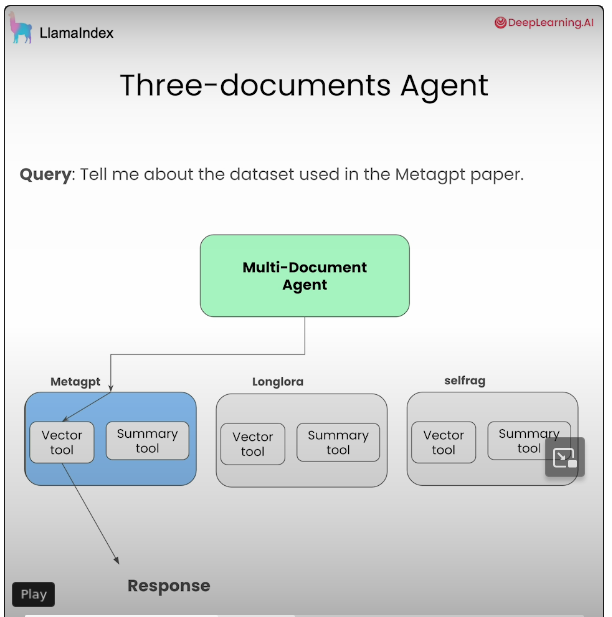

In [53]:
Image(filename="../Imgs/20240516_230659.png") 

## Setup an agent over 3 papers

In [55]:
## Uncomment if not ran before
#from llama_index.llms.openai import OpenAI
#llm = OpenAI(model="gpt-3.5-turbo")
#import nest_asyncio
#nest_asyncio.apply()
#from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, SummaryIndex
#from llama_index.core.node_parser import SentenceSplitter
#from llama_index.core.tools import FunctionTool, QueryEngineTool
#from llama_index.core.vector_stores import MetadataFilters, FilterCondition
from typing import List, Optional
from pathlib import Path

In [54]:
def get_doc_tools(file_path: str, name: str,) -> str:
    """Get vector query and summary query tools from a document."""

    documents = SimpleDirectoryReader(input_files=[file_path]).load_data()
    splitter = SentenceSplitter(chunk_size=1024)
    nodes = splitter.get_nodes_from_documents(documents)
    
    vector_index = VectorStoreIndex(nodes)
    
    def vector_query(query: str, page_numbers: Optional[List[str]] = None) -> str:
        """Use to answer questions over a given paper.
    
        Useful if you have specific questions over the paper.
        Always leave page_numbers as None UNLESS there is a specific page you want to search for.
    
        Args:
            query (str): the string query to be embedded.
            page_numbers (Optional[List[str]]): Filter by set of pages. Leave as NONE 
                if we want to perform a vector search
                over all pages. Otherwise, filter by the set of specified pages.
        
        """
    
        page_numbers = page_numbers or []
        metadata_dicts = [{"key": "page_label", "value": p} for p in page_numbers]
        query_engine = vector_index.as_query_engine(similarity_top_k=2,
                                                    filters=MetadataFilters.from_dicts(metadata_dicts,
                                                                                       condition=FilterCondition.OR)
                                                   )
        response = query_engine.query(query)
        return response
    
    vector_query_tool = FunctionTool.from_defaults(name=f"vector_tool_{name}", fn=vector_query)
    
    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(response_mode="tree_summarize",
                                                         use_async=True,)
    summary_tool = QueryEngineTool.from_defaults(name=f"summary_tool_{name}",
                                                 query_engine=summary_query_engine,
                                                 description=(f"Useful for summarization questions related to {name}"),)

    return vector_query_tool, summary_tool

In [ ]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=hSyW5go0v8",
]

papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "selfrag.pdf",
]

In [ ]:
paper_to_tools_dict = {}
for paper in papers:
    print(f"Getting tools for paper: {paper}")
    vector_tool, summary_tool = get_doc_tools(paper, Path(paper).stem)
    paper_to_tools_dict[paper] = [vector_tool, summary_tool]

In [ ]:
initial_tools = [t for paper in papers for t in paper_to_tools_dict[paper]]